In [1]:
import imageio as igio
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy as scpy

In [2]:
def my_mse( A, B):
#     if( A.shape != B.shape):
#         print('Both matrixes are of same dimensions\n')
    counter = 0
    for i in range(0,A.shape[0]):
        for j in range(0,A.shape[1]):
            counter += (A[i,j]- B[i,j])*(A[i,j]- B[i,j])
    print( np.sqrt(counter)/(A.shape[0]*A.shape[1]) )

In [10]:
#size of the denoising filter kernel (if type 1) or size of degradation function (if
#type 2), k ∈ [3, 5, 7, 9, 11],
#Afterwards, if the type of filter is 1 (denoising), get the following input:
# • mode for denoising mode = "average" or "robust",
# Otherwise, if the type of filter is 2 (deblurring), then
# • sigma for the degradation function σ > 0.

def my_scale( img_orig, img_dest  ):
    img_scaled = np.zeros(img_orig.shape)
    
    a = np.min(img_orig)
    b = np.max(img_orig)
    
    img_dest_min = np.min(img_dest)
    img_dest_max = np.max(img_dest)
    
    for i in range(img_dest.shape[0]):
        for j in range(img_dest.shape[1]):
            img_scaled[i,j] = (b - a)*(img_dest[i,j]-img_dest_min)/(img_dest_max-img_dest_min) + a
    
    return img_scaled

def my_fun(name_reference, name_degraded, F, gamma, size_denoising_filter, denoising_type, sigma ):
    
    img_reference =igio.imread(name_reference)
    print(img_reference.shape)
    img_degraded =igio.imread(name_degraded)
    print(img_degraded.shape)
    
    img_f = np.zeros(img_degraded.shape)
    print(img_f.shape)
    
    ##Copy of values with no filter passing
    
    img_f[0, 0:img_reference.shape[1]-1] = img_reference[0, 0:img_reference.shape[1]-1]
    img_f[img_reference.shape[0]-1, 0:img_reference.shape[1]-1] = img_reference[img_reference.shape[0]-1, 0:img_reference.shape[1]-1]
    
    img_f[0:img_reference.shape[0]-1, 0] = img_reference[0:img_reference.shape[0]-1, 0]
    img_f[0:img_reference.shape[0]-1, img_reference.shape[1]-1] = img_reference[0:img_reference.shape[0]-1, img_reference.shape[1]-1]
    print(img_f)
    
    ##Clarify disp_n is only calculates on [0,1/6*m], [0,1/6*n]
    
    x_d = int(np.floor(img_degraded.shape[0]/6)) ##Clarify what is m or n???
    y_d = int(np.floor(img_degraded.shape[1]/6))
    
    n_range = np.zeros([1, x_d*y_d])
    idx = 0
    for x in range(0,x_d):
        for y in range(0,y_d):
            n_range[0, idx] = img_degraded[x,y]
            idx += 1
        disp_n = np.std(n_range)
    
     ##Error Checking disp_n
    if disp_n == 0:
        disp_n = 1
    
    print('disp_n ', disp_n)
    
    ##Adaptative Denoising
    for i in range(1, img_degraded.shape[0]-2):
        for j in range(1, img_degraded.shape[1]-2):
#             print(i,j)
            
#             ##Clarify disp_n is only calculates on [0,1/6*m], [0,1/6*n]
#             n_range = np.zeros([1, x_d*y_d])
#             idx = 0
#             for x in range(0,x_d):
#                 for y in range(0,y_d):
#                     n_range[0, idx] = img_degraded[x,y]
#                     idx += 1
#             disp_n = np.std(n_range)
           
            
            ##Calculate disp_l
            val = int(np.floor(size_denoising_filter.shape[1]/2))
                
            l_range = np.zeros([1, int(size_denoising_filter.shape[0]*size_denoising_filter.shape[1]) - 1])
            
            idx = 0
            
            inc_i = -val
#             print('i j : ', i, j)
            for n_i in range(0, size_denoising_filter.shape[0]):
                inc_j = -val
                for n_j in range(0, size_denoising_filter.shape[1]):
                    if( not(n_i == 1 & n_j == 1) ):
                        l_range[0, idx] = img_degraded[i + inc_i, j + inc_j]
#                         print(l_range)
                        idx += 1
                    inc_j += 1
                inc_i += 1
            
            disp_l = np.std(l_range)
            
            ##Error checking
            if (disp_l == 0):
                disp_l = disp_n
            
            ##Calculate centr_l
            centr_l = 0
            if(denoising_type == 'average'):
                centr_l = np.average(l_range)
            elif(denoising_type == 'robust'):
                centrl_l = np.median(l_range)
            
            
            img_f[i,j] = img_degraded[i,j] - gamma * disp_n/disp_l * (img_degraded[i,j] - centr_l)
            
    igio.imwrite('im_ori.png', img_f.astype('uint8'))
    
    img_f = my_scale(img_reference, img_f)
    
    igio.imwrite('im_norm.png', img_f.astype('uint8'))

In [11]:
import time
start = time.time()

my_fun(name_reference='camera_saltpepper.png', name_degraded='camera_saltpepper.png', F=1, gamma=0.5, size_denoising_filter=np.zeros([3,3]), denoising_type='average', sigma = 0 )

end = time.time()
print(end - start)


(256, 256)
(256, 256)
(256, 256)
[[156. 159. 158. ... 151. 152. 152.]
 [255.   0.   0. ...   0.   0.   0.]
 [156.   0.   0. ...   0.   0. 152.]
 ...
 [114.   0.   0. ...   0.   0. 114.]
 [  0.   0.   0. ...   0.   0. 113.]
 [121. 126. 130. ...   0. 130.   0.]]
disp_n  36.071365707944594
6.5272393226623535


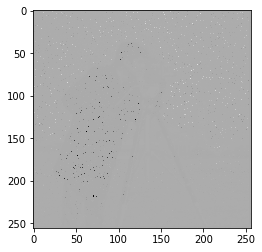

In [21]:
im = igio.imread('camera_saltpepper.png')
fig = plt.imshow(im, cmap = plt.get_cmap(name = 'gray'))

im = igio.imread('im_ori.png')
fig = plt.imshow(im, cmap = plt.get_cmap(name = 'gray'))

im = igio.imread('im_norm.png')
fig = plt.imshow(im, cmap = plt.get_cmap(name = 'gray'))
